In [1]:
pip install optuna-integration[sklearn]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
df=pd.read_csv("socio_demo_psychology.csv")
df.head()

,age,gender,sex,education,Employment_status,Personal_Net_Income_Category,Ethnic_Background,living_arrangement,marital_status,hours_on_social_media,...,extraversion,self_esteem,composite_values,mhi5_class_2022,gender.1,Religion,Religious_Membership,political_interest,mhi5_std_score_2022,nomem_encr
0,60.0,999,1.0,6.0,1,7.0,2.0,3.0,1.0,2.0,...,2.1,6.2,5.750000,0.0,999,NaN,2.0,1.0,84.0,800015
1,32.0,999,2.0,4.0,1,4.0,2.0,3.0,1.0,18.0,...,3.5,5.2,6.500000,1.0,999,10.0,1.0,2.0,52.0,800100
2,49.0,999,1.0,4.0,1,4.0,1.0,2.0,1.0,17.0,...,3.7,3.9,4.638889,0.0,999,NaN,2.0,2.0,64.0,800201
3,70.0,999,1.0,6.0,9,6.0,1.0,2.0,1.0,0.0,...,3.6,5.8,4.777778,0.0,999,NaN,2.0,1.0,76.0,800228
4,60.0,999,1.0,4.0,4,5.0,1.0,3.0,1.0,6.0,...,3.7,6.1,4.833333,0.0,999,NaN,2.0,1.0,88.0,800392


In [3]:
import pandas as pd

# Define the target variable
target_column = ['mhi5_class_2022']

# Columns that are inside blocks but MAY only be needed for error analysis
possible_error_analysis_columns = ['gender', 'Religion', 'Religious_Membership', 'political_interest','mhi5_std_score_2022', 'gender.1', 'Ethnic_Background', 'social_media_frequency' ]

# Full list of extra columns
keep_columns = target_column + possible_error_analysis_columns  


# Separate features and target
X = df.drop(columns=keep_columns)  # Drop target + uncertain columns for training
y = df[target_column[0]]  # Target variable


In [4]:
print(X.shape)
print(y.shape)

(995, 17)
(995,)


In [5]:
X= X.reset_index(drop=True)
y= y.reset_index(drop=True)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 995 entries, 0 to 994
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           995 non-null    float64
 1   sex                           995 non-null    float64
 2   education                     993 non-null    float64
 3   Employment_status             995 non-null    int64  
 4   Personal_Net_Income_Category  993 non-null    float64
 5   living_arrangement            995 non-null    float64
 6   marital_status                995 non-null    float64
 7   hours_on_social_media         995 non-null    float64
 8   loneliness_score              995 non-null    int64  
 9   emotional_stability           995 non-null    float64
 10  intellect_imagination         995 non-null    float64
 11  conscientiousness             995 non-null    float64
 12  agreeableness                 995 non-null    float64
 13  extra

In [7]:
print(X.isna().sum()) 

age                             0
sex                             0
education                       2
Employment_status               0
Personal_Net_Income_Category    2
living_arrangement              0
marital_status                  0
hours_on_social_media           0
loneliness_score                0
emotional_stability             0
intellect_imagination           0
conscientiousness               0
agreeableness                   0
extraversion                    0
self_esteem                     1
composite_values                1
nomem_encr                      0
dtype: int64


In [8]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# List of columns with missing values
columns_with_na = ['education', 'Personal_Net_Income_Category', 'self_esteem', 
                   'composite_values']

# Apply the imputer to the specified columns
X[columns_with_na] = imputer.fit_transform(X[columns_with_na])

# Check if the missing values are imputed
print(X.isna().sum())


age                             0
sex                             0
education                       0
Employment_status               0
Personal_Net_Income_Category    0
living_arrangement              0
marital_status                  0
hours_on_social_media           0
loneliness_score                0
emotional_stability             0
intellect_imagination           0
conscientiousness               0
agreeableness                   0
extraversion                    0
self_esteem                     0
composite_values                0
nomem_encr                      0
dtype: int64


In [9]:
print(y.isna().sum())
print(y.dtype)

1
float64


In [10]:
y.dropna(inplace=True)  #drop the entry with nan
X = X.loc[y.index]    # keep X and y aligned


Split Train_test

In [12]:
from sklearn.model_selection import train_test_split

# Stratified train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
X_train = X_train.drop(columns=["nomem_encr"], errors="ignore")
X_test = X_test.drop(columns=["nomem_encr"], errors="ignore")  # if needed


Nested Cross Validation

Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import joblib

# Sampler dictionary
samplers = {
    'none': None,
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# Hyperparameter grid
param_grid_lr = {
    'sampler': [samplers['none'], samplers['undersample'], samplers['smotetomek']],
    'classifier__C': [0.01, 0.1, 1, 10]
}

# Pipeline
pipeline_lr = ImbPipeline([
    ('sampler', SMOTETomek()),  # wordt geswitched op basis van de param_grid_lr
    ('scaler', StandardScaler()), # hier doen na datasplit anders dataleakage niet bij preprocessing.
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# GridSearch
grid_lr = GridSearchCV(pipeline_lr, param_grid=param_grid_lr, cv=3, scoring='f1', n_jobs=-1) # cv gaat automatisch stratifiedsplit. hier zetten ze in plats van 3 ook inner_cv

# nested cross_validation
from sklearn.model_selection import cross_validate
nested_cv_search = cross_validate(
    grid_lr,
    X=X_train,
    y=y_train,
    cv=5, #hier kunnen ze ook outer_cv zetten ipv 5 
    scoring='f1',
    error_score='raise',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)
print("Nested CV results:")
print(nested_cv_search['test_score'])
print("Mean F1 score:", nested_cv_search['test_score'].mean())
print('STD F1 score:', nested_cv_search['test_score'].std())
best_score_index = np.argmax(nested_cv_search['test_score'])
best_model = nested_cv_search['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)
# print the parameters of all 5 models
for i, model in enumerate(nested_cv_search['estimator']):
    print(f"Model {i+1} parameters: {model.best_params_}")

# sla de nested_cv op
joblib.dump(nested_cv_search, 'nested_cv_search_lr_social+demo+psy.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Nested CV results:
[0.65789474 0.62790698 0.58823529 0.60674157 0.51685393]
Mean F1 score: 0.5995265026643832
STD F1 score: 0.04738481728265129
Parameters of the best model: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 1 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 2 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 3 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 4 parameters: {'classifier__C': 0.01, 'sampler': SMOTETomek(random_state=42)}
Model 5 parameters: {'classifier__C': 1, 'sampler': SMOTETomek(random_state=42)}


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


['nested_cv_search_lr_social+demo+psy.pkl']

## **Random Forest**

In [18]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, CategoricalDistribution
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold, cross_validate
import numpy as np
import joblib

# Set Optuna_study for reproducibility
optuna.logging.set_verbosity(optuna.logging.WARNING) # Set Optuna logging

# Create a study manually
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)
)

# Sampler dictionary
samplers = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# Mapping for resolving samplers
sampler_map = {
    'none': 'passthrough',
    'undersample': samplers['undersample'],
    'smotetomek': samplers['smotetomek']
}

# Custom pipeline
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# Pipeline
pipeline_rf = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),  # placeholder
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Hyperparameter search space
param_distributions_rf = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': IntDistribution(50, 250, step=50),
    'classifier__max_depth': CategoricalDistribution([None, 5, 10, 15, 20]),
    'classifier__max_features': CategoricalDistribution(['sqrt', 'log2']),
    'classifier__min_samples_split': IntDistribution(2, 10),
    'classifier__min_samples_leaf': IntDistribution(1, 4)
}

# Now OptunaSearchCV with study=optuna_study
optuna_search_rf = OptunaSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_distributions_rf,
    cv=3,
    n_trials=50,
    study=optuna_study,   # <<< use study here!
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Outer CV: Nested Cross-Validation
nested_cv_search = cross_validate(
    optuna_search_rf,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='f1',
    error_score='raise',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# Results
print("Nested CV results:")
print(nested_cv_search['test_score'])
print("Mean F1 score:", nested_cv_search['test_score'].mean())
print("STD F1 score:", nested_cv_search['test_score'].std())

# Best model across folds
best_score_index = np.argmax(nested_cv_search['test_score'])
best_model = nested_cv_search['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

# Parameters of all models
for i, model in enumerate(nested_cv_search['estimator']):
    print(f"Model {i+1} parameters: {model.best_params_}")

# Save results
joblib.dump(nested_cv_search, 'nested_cv_search_rf_social+demo+psy.pkl')

C:\Users\u1246538\AppData\Local\Temp\ipykernel_10440\1145310708.py:61: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_rf = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.8s finished


Nested CV results:
[0.65625    0.63013699 0.53191489 0.64102564 0.51948052]
Mean F1 score: 0.5957616080849103
STD F1 score: 0.057938851022561313
Parameters of the best model: {'sampler': 'smotetomek', 'classifier__n_estimators': 150, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 4}
Model 1 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 150, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 4}
Model 2 parameters: {'sampler': 'smotetomek', 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 3}
Model 3 parameters: {'sampler': 'undersample', 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_split': 7, 'classifier__min_sam

['nested_cv_search_rf_social+demo+psy.pkl']

SVM

In [20]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import joblib

# 1. Define sampler map
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# 2. Custom pipeline
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

# 3. Define search space
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__kernel': CategoricalDistribution(['linear', 'rbf', 'poly']),
    'classifier__C': FloatDistribution(0.1, 100, log=True),
    'classifier__gamma': CategoricalDistribution(['scale', 'auto', 0.1, 0.01, 0.001]),
    'classifier__degree': IntDistribution(2, 5),
    'classifier__class_weight': CategoricalDistribution([None, 'balanced'])
}

# 4. Create fixed study
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Control randomness
)

# 5. Setup OptunaSearchCV
optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,
    n_trials=50,
    study=optuna_study,   
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 6. Outer nested CV
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_train,
    y=y_train,
    cv=outer_cv,
    scoring='f1',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# 7. Results
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))

print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")

best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print("Parameters of the best overall model:", best_model.best_params_)

# Save 
joblib.dump(nested_cv_results, 'nested_cv_optuna_svm_social+demo+psy.pkl')

C:\Users\u1246538\AppData\Local\Temp\ipykernel_10440\1227646853.py:51: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV F1 scores: [0.54761905 0.65217391 0.63157895 0.60674157 0.60674157]
Mean F1 score: 0.6089710108196725
STD F1 score: 0.03507595680749353
Best parameters per fold:
Fold 1: {'sampler': 'undersample', 'classifier__kernel': 'rbf', 'classifier__C': 4.749858586202272, 'classifier__gamma': 0.001, 'classifier__degree': 2, 'classifier__class_weight': None}
Fold 2: {'sampler': 'none', 'classifier__kernel': 'rbf', 'classifier__C': 28.25904792656664, 'classifier__gamma': 0.001, 'classifier__degree': 5, 'classifier__class_weight': 'balanced'}
Fold 3: {'sampler': 'smotetomek', 'classifier__kernel': 'rbf', 'classifier__C': 0.6402537112112124, 'classifier__gamma': 0.01, 'classifier__degree': 3, 'classifier__class_weight': None}
Fold 4: {'sampler': 'none', 'classifier__kernel': 'linear', 'classifier__C': 36.23838096445945, 'classifier__gamma': 'auto', 'classifier__degree': 5, 'classifier__class_weight': 'balanced'}
Fold 5: {'sampler': 'smotetomek', 'classifier__kernel': 'rbf', 'classifier__C':

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   19.6s finished


['nested_cv_optuna_svm_social+demo+psy.pkl']

XGBoost

In [22]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, FloatDistribution, IntDistribution
import numpy as np
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.base import clone
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# 1. Define your sampler map
sampler_map = {
    'none': 'passthrough',
    'undersample': RandomUnderSampler(random_state=42),
    'smotetomek': SMOTETomek(random_state=42)
}

# 2. Custom pipeline class that resolves sampler strings
class SamplerResolvingPipeline(ImbPipeline):
    def set_params(self, **kwargs):
        if 'sampler' in kwargs and isinstance(kwargs['sampler'], str):
            kwargs['sampler'] = sampler_map[kwargs['sampler']]
        return super().set_params(**kwargs)

# 3. Define the pipeline
pipeline = SamplerResolvingPipeline([
    ('sampler', 'passthrough'),  # will be overridden
    ('scaler', StandardScaler()),
    ('classifier', xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42))
])

# 4. Define Optuna-compatible search space based on the provided hyperparameters
param_distributions = {
    'sampler': CategoricalDistribution(['none', 'undersample', 'smotetomek']),
    'classifier__n_estimators': CategoricalDistribution([50, 100, 200, 400, 500]),
    'classifier__learning_rate': FloatDistribution(0.01, 0.1, log=True),
    'classifier__max_depth': CategoricalDistribution([2, 4, 6, 10, 15]),
    'classifier__min_child_weight': CategoricalDistribution([1, 3, 5]),
    'classifier__subsample': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__colsample_bytree': CategoricalDistribution([0.6, 0.8, 1.0]),
    'classifier__gamma': FloatDistribution(0.0, 1.0, step=0.1),
    'classifier__reg_alpha': FloatDistribution(0.001, 5.0, log=True),  # L1 regularization
    'classifier__reg_lambda': FloatDistribution(0.001, 5.0, log=True),  # L2 regularization
}


# 5. Create fixed study
optuna.logging.set_verbosity(optuna.logging.WARNING)
optuna_study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Control randomness
)

# 6. Setup OptunaSearchCV (inner CV: 3-fold)
optuna_search = OptunaSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=3,  # inner CV with 3 folds
    n_trials=50,
    study=optuna_study,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 7. Outer nested cross-validation (5-fold)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
nested_cv_results = cross_validate(
    optuna_search,
    X=X_train,
    y=y_train,
    cv=outer_cv,
    scoring='f1',
    return_estimator=True,
    return_train_score=False,
    verbose=1,
    n_jobs=-1
)

# 7. Print and save results
print("Nested CV F1 scores:", nested_cv_results['test_score'])
print("Mean F1 score:", np.mean(nested_cv_results['test_score']))
print("STD F1 score:", np.std(nested_cv_results['test_score']))
print("Best parameters per fold:")
for i, model in enumerate(nested_cv_results['estimator']):
    print(f"Fold {i+1}: {model.best_params_}")

best_score_index = np.argmax(nested_cv_results['test_score'])
best_model = nested_cv_results['estimator'][best_score_index]
print("Parameters of the best overall model:", best_model.best_params_)

# Save the results
joblib.dump(nested_cv_results, 'nested_cv_optuna_xgb_social+demo+psy.pkl')

C:\Users\u1246538\AppData\Local\Temp\ipykernel_10440\4171778954.py:58: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
C:\Users\u1246538\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:125: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  new_object = klass(**new_object_params)


Nested CV F1 scores: [0.51764706 0.6835443  0.6        0.58426966 0.68421053]
Mean F1 score: 0.6139343103716272
STD F1 score: 0.0634502779138831
Best parameters per fold:
Fold 1: {'sampler': 'smotetomek', 'classifier__n_estimators': 50, 'classifier__learning_rate': 0.0467797044504632, 'classifier__max_depth': 2, 'classifier__min_child_weight': 1, 'classifier__subsample': 0.6, 'classifier__colsample_bytree': 0.6, 'classifier__gamma': 0.8, 'classifier__reg_alpha': 0.160313395219896, 'classifier__reg_lambda': 0.001675430661531016}
Fold 2: {'sampler': 'smotetomek', 'classifier__n_estimators': 500, 'classifier__learning_rate': 0.043125551532002815, 'classifier__max_depth': 15, 'classifier__min_child_weight': 5, 'classifier__subsample': 0.6, 'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.9, 'classifier__reg_alpha': 4.387383526493811, 'classifier__reg_lambda': 3.9776905237427695}
Fold 3: {'sampler': 'smotetomek', 'classifier__n_estimators': 100, 'classifier__learning_rate': 0.010

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.1s finished


['nested_cv_optuna_xgb_social+demo+psy.pkl']

# *Find Best model(highest mean F1) and test on Hold_out Test Set*

In [24]:
from sklearn.metrics import classification_report
import joblib
import numpy as np

# Load nested CV results
models_info = {
    "LogisticRegression": joblib.load("nested_cv_search_lr_social+demo+psy.pkl"),
    "RandomForest": joblib.load("nested_cv_search_rf_social+demo+psy.pkl"),
    "SVM": joblib.load("nested_cv_optuna_svm_social+demo+psy.pkl"),
    "XGBoost": joblib.load("nested_cv_optuna_xgb_social+demo+psy.pkl"),
}

# Compare mean F1 scores
for name, result in models_info.items():
    mean_f1 = np.mean(result['test_score'])
    std_f1 = np.std(result['test_score'])
    print(f"{name}: Mean F1 = {mean_f1:.4f}, Std = {std_f1:.4f}")

# Find best model by mean F1 score
best_model_name = max(models_info, key=lambda name: np.mean(models_info[name]['test_score']))
best_model_cv = models_info[best_model_name]
best_index = np.argmax(best_model_cv['test_score'])
best_estimator = best_model_cv['estimator'][best_index]

print(f"\nBest model: {best_model_name} (fold {best_index+1})")
print("Best estimator params:", best_estimator.best_params_)

# Evaluate on test set 2022
y_pred = best_estimator.predict(X_test)
print(f"\n=== Evaluation of {best_model_name} on Test Set ===")
print(classification_report(y_test, y_pred))


LogisticRegression: Mean F1 = 0.5995, Std = 0.0474
RandomForest: Mean F1 = 0.5958, Std = 0.0579
SVM: Mean F1 = 0.6090, Std = 0.0351
XGBoost: Mean F1 = 0.6139, Std = 0.0635

Best model: XGBoost (fold 5)
Best estimator params: {'sampler': 'smotetomek', 'classifier__n_estimators': 200, 'classifier__learning_rate': 0.014622862892525726, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__subsample': 0.6, 'classifier__colsample_bytree': 1.0, 'classifier__gamma': 0.30000000000000004, 'classifier__reg_alpha': 0.09857598844128469, 'classifier__reg_lambda': 3.7331061386307467}

=== Evaluation of XGBoost on Test Set ===
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.87       157
         1.0       0.51      0.62      0.56        42

    accuracy                           0.79       199
   macro avg       0.70      0.73      0.71       199
weighted avg       0.81      0.79      0.80       199



## **More evaluation Metrics**

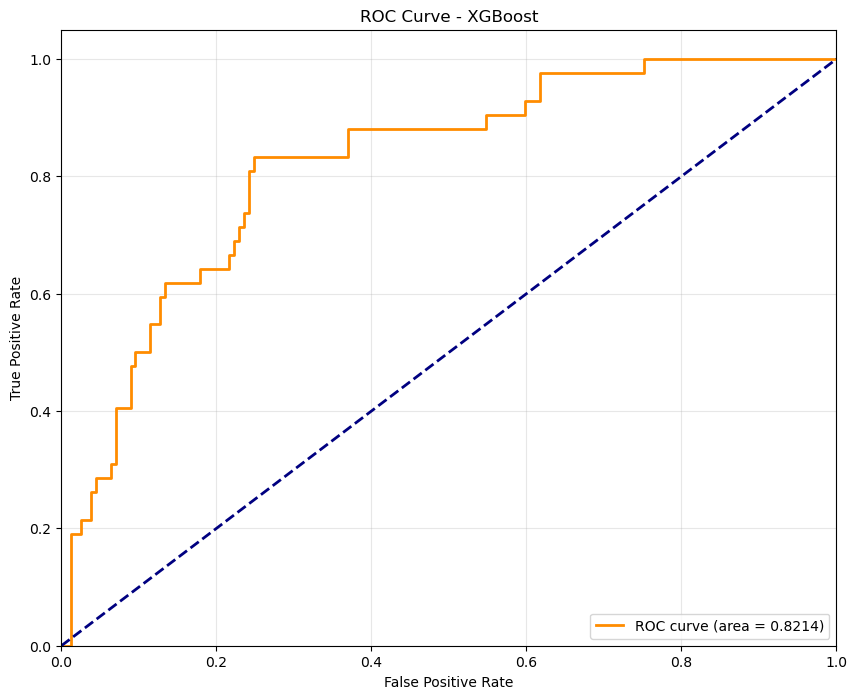

AUC-ROC: 0.8214


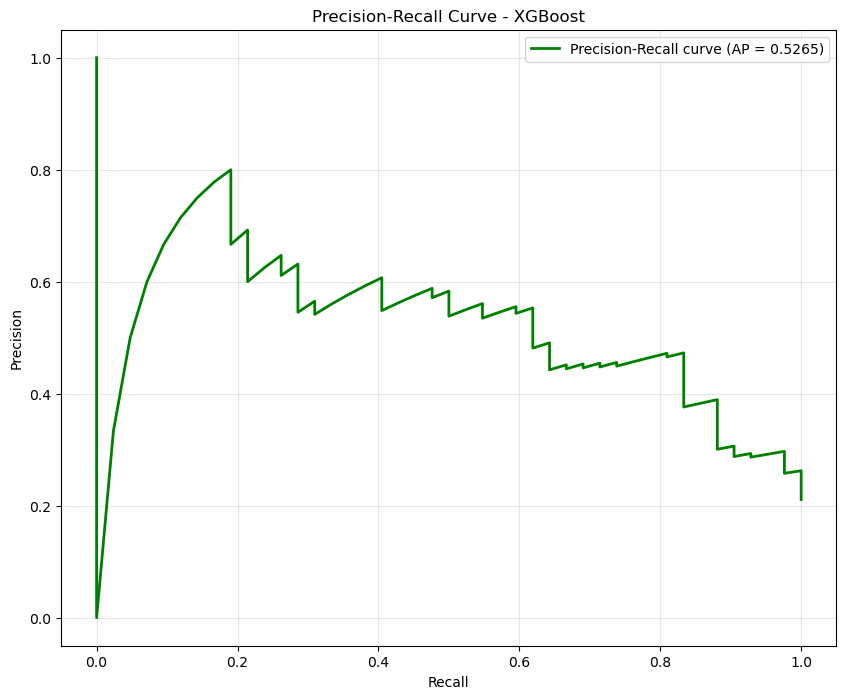

Average Precision: 0.5265


<Figure size 800x600 with 0 Axes>

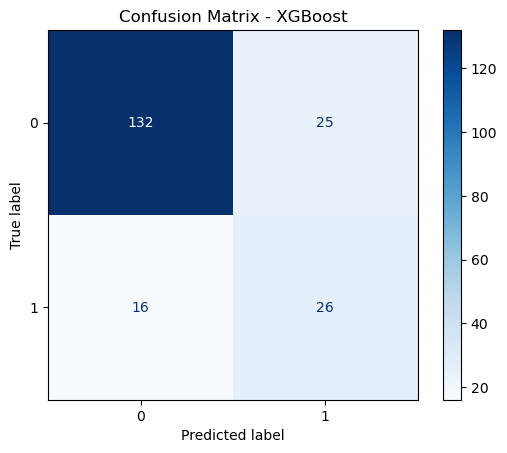


Confusion Matrix:
True Negatives: 132
False Positives: 25
False Negatives: 16
True Positives: 26

Calculating Permutation Feature Importance...


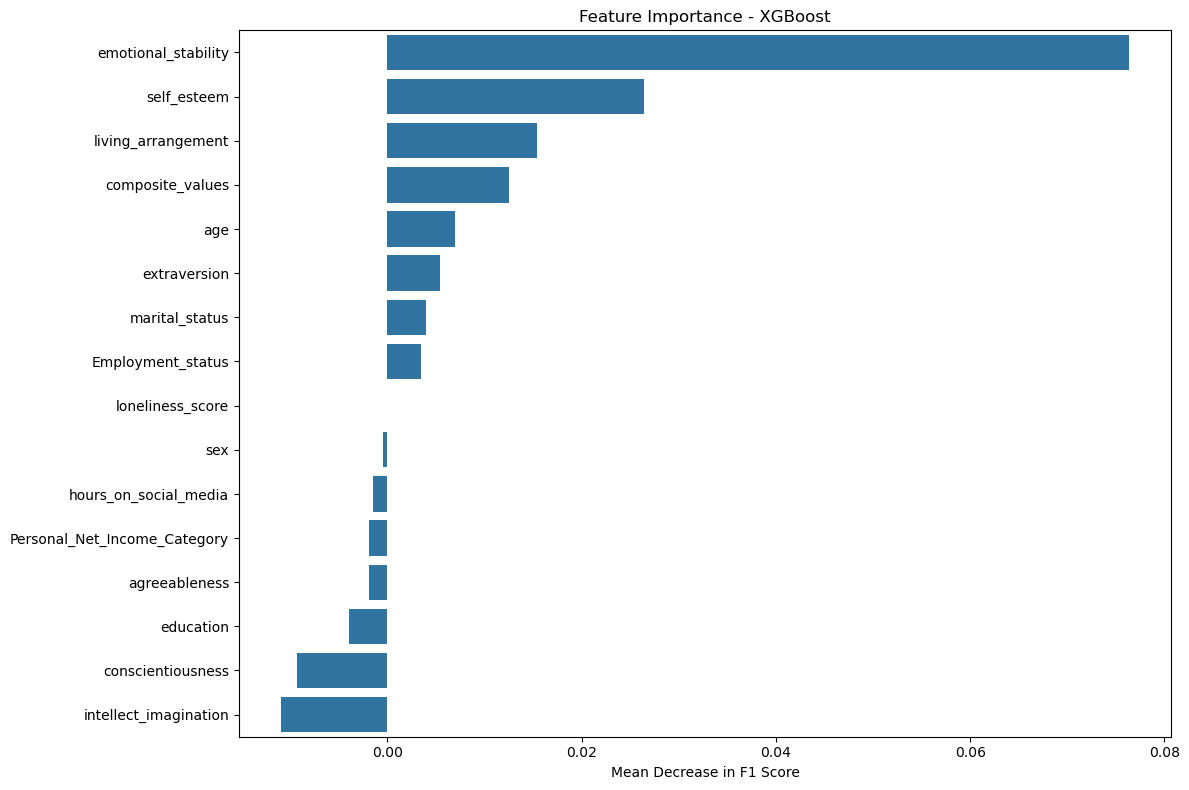


Top 10 Most Important Features:
emotional_stability: 0.0763 ± 0.0183
self_esteem: 0.0265 ± 0.0178
living_arrangement: 0.0154 ± 0.0042
composite_values: 0.0125 ± 0.0077
age: 0.0070 ± 0.0105
extraversion: 0.0055 ± 0.0027
marital_status: 0.0040 ± 0.0034
Employment_status: 0.0035 ± 0.0032
loneliness_score: 0.0000 ± 0.0000
sex: -0.0004 ± 0.0078


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.inspection import permutation_importance

# We already have y_pred from the code above
# Get probabilities if the model supports it
if hasattr(best_estimator, "predict_proba"):
    y_proba = best_estimator.predict_proba(X_test)[:, 1]
    
    # === ROC Curve ===
    plt.figure(figsize=(10, 8))
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    # === Precision-Recall Curve ===
    plt.figure(figsize=(10, 8))
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, color='green', lw=2, 
             label=f'Precision-Recall curve (AP = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {best_model_name}')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"Average Precision: {pr_auc:.4f}")
else:
    print(f"Note: {best_model_name} does not support probability predictions for ROC and PR curves")

# === Confusion Matrix ===
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

# === Permutation Feature Importance ===
print("\nCalculating Permutation Feature Importance...")
result = permutation_importance(
    best_estimator, 
    X_test, 
    y_test, 
    scoring='f1_weighted', 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Get feature names
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]

# Sort features by importance
sorted_idx = result.importances_mean.argsort()[::-1]

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x=result.importances_mean[sorted_idx], 
    y=[feature_names[i] for i in sorted_idx]
)
plt.title(f"Feature Importance - {best_model_name}")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()

# Print top features with importance values
print("\nTop 10 Most Important Features:")
for i in sorted_idx[:10]:
    feature_name = feature_names[i]
    print(f"{feature_name}: {result.importances_mean[i]:.4f} ± {result.importances_std[i]:.4f}")

# ** Evaluate estimated best model on Test set 2023**

In [52]:
# Step 1: Import the 2023 data with MHI-5 outcomes
mhi_df_2023 = pd.read_csv(r"C:\Users\u1246538\Downloads\liss-data\Notebooks_MHI-5\merged_df_2023_cleaned_with_traits_and_values_cleaned_final_cleaned.csv")

# Step 2: Extract only the necessary columns using the actual column names
mhi_subset_2023 = mhi_df_2023[['nomem_encr', 'class', 'standardized_score']]

# Step 3: Rename columns to match our expected naming convention for consistency
mhi_subset_2023 = mhi_subset_2023.rename(columns={
    'class': 'MHI5_class_2023',
    'standardized_score': 'MHI5_std_score_2023'
})

# Step 4: Merge with your original socio_demo_health dataframe
df_2023 = pd.read_csv("socio_demo_psychology.csv")
merged_df_2023 = df_2023.merge(mhi_subset_2023, on='nomem_encr', how='left')

print("Merged 2023 Data Shape:", merged_df_2023.shape)
# Step 5: Prepare the 2023 features using the same transformations as 2022
# Keep only the same predictors that you used for X in 2022
X_2023 = merged_df_2023.drop(columns=keep_columns + ['MHI5_class_2023', 'MHI5_std_score_2023'])
y_2023 = merged_df_2023['MHI5_class_2023']


print("X_2023 Shape:", X_2023.shape, X.info())
print('-------------------------')
print("y_2023 Shape:", y_2023.shape, y.info())
print('-------------------------')
print("Missing values in X is...", X_2023.isna().sum())
print("Missing values in y is...", y_2023.isna().sum())

Merged 2023 Data Shape: (995, 28)
<class 'pandas.core.frame.DataFrame'>
Index: 994 entries, 0 to 994
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   age                           994 non-null    float64
 1   sex                           994 non-null    float64
 2   education                     994 non-null    float64
 3   Employment_status             994 non-null    int64  
 4   Personal_Net_Income_Category  994 non-null    float64
 5   living_arrangement            994 non-null    float64
 6   marital_status                994 non-null    float64
 7   hours_on_social_media         994 non-null    float64
 8   loneliness_score              994 non-null    int64  
 9   emotional_stability           994 non-null    float64
 10  intellect_imagination         994 non-null    float64
 11  conscientiousness             994 non-null    float64
 12  agreeableness                 994 n

In [54]:
# Reset indices
X_2023 = X_2023.reset_index(drop=True)
y_2023 = y_2023.reset_index(drop=True)

# Apply the same imputation strategy used for 2022 data
X_2023[columns_with_na] = imputer.transform(X_2023[columns_with_na])

# Ensure y_2023 is a Series, not a DataFrame
if isinstance(y_2023, pd.DataFrame):
    y_2023 = y_2023.squeeze()

# Drop NAN and align features
y_2023=y_2023.dropna()
X_2023 = X_2023.loc[y_2023.index]

#final check before split
print("NaNs in y_2023 before split:", y_2023.isna().sum())
print("y_2023 shape:", y_2023.shape)
print("X_2023 shape:", X_2023.shape)


NaNs in y_2023 before split: 0
y_2023 shape: (895,)
X_2023 shape: (895, 17)


In [56]:
# Split the 2023 data using the same approach as 2022
X_train_2023, X_test_2023, y_train_2023, y_test_2023 = train_test_split(
    X_2023, y_2023, test_size=0.2, random_state=42, stratify=y_2023
)

# NEW: Drop 'nomem_encr' from test set only bc you only evaluate on test set, no need of training set here
X_test_2023_clean = X_test_2023.drop(columns=["nomem_encr"], errors="ignore")

# Now you can use X_test_2023_clean safely for prediction:
y_pred_2023 = best_model.predict(X_test_2023_clean)
#Before train_test_split, you need nomem_encr for aligning the merge.
#After the split, you have X_train_2023 and X_test_2023.
#Only in X_test_2023, you drop 'nomem_encr' right before prediction.

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# You've already identified the best model from 2022
# best_model_name = max(models_info, key=lambda name: np.mean(models_info[name]['test_score']))
# best_model_cv = models_info[best_model_name]
# best_index = np.argmax(best_model_cv['test_score'])
# best_estimator = best_model_cv['estimator'][best_index]

# Drop ID column before predicting
X_test_2023_clean = X_test_2023.drop(columns=["nomem_encr"], errors="ignore")

# Predict using the best model from 2022
y_pred_2023 = best_estimator.predict(X_test_2023_clean)

print(f"\n=== Evaluation of {best_model_name} on 2023 Test Set ===")
print(classification_report(y_test_2023, y_pred_2023))


=== Evaluation of XGBoost on 2023 Test Set ===
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88       144
         1.0       0.52      0.63      0.57        35

    accuracy                           0.82       179
   macro avg       0.71      0.74      0.73       179
weighted avg       0.83      0.82      0.82       179



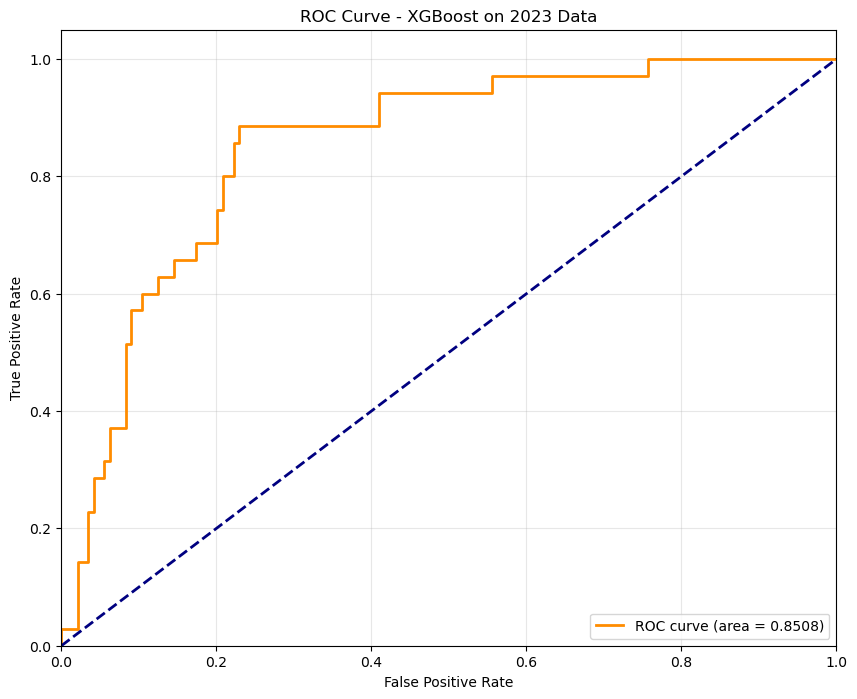

AUC-ROC (2023): 0.8508


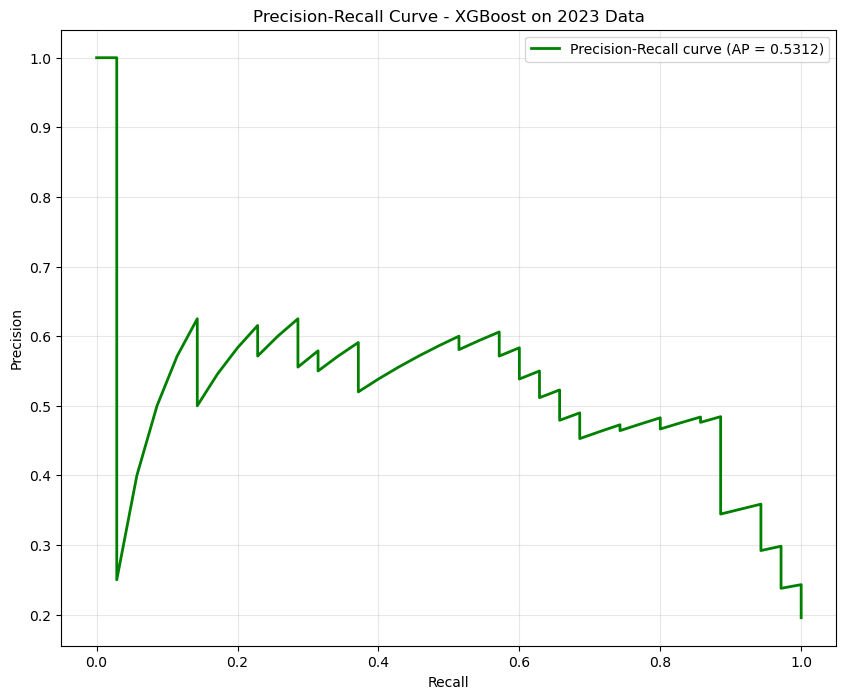

Average Precision (2023): 0.5312


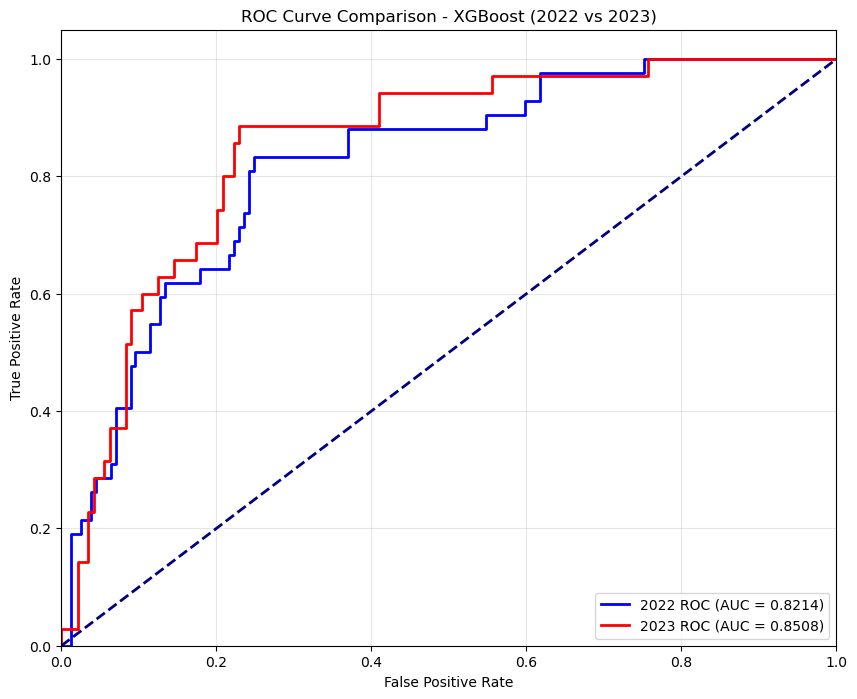

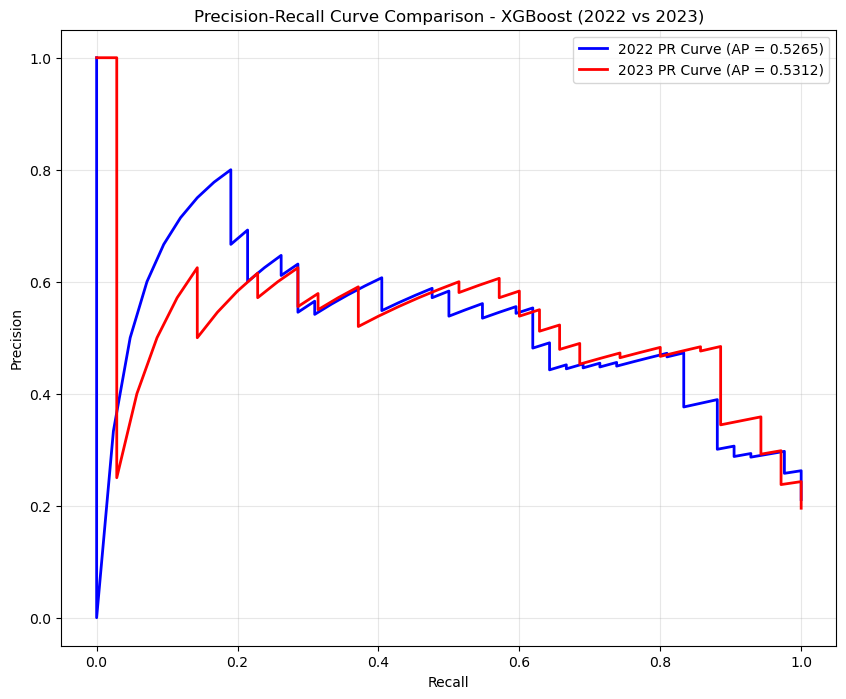

<Figure size 800x600 with 0 Axes>

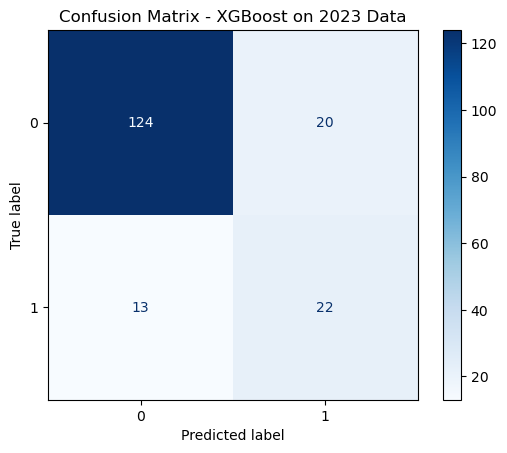


Confusion Matrix (2023):
True Negatives: 124
False Positives: 20
False Negatives: 13
True Positives: 22


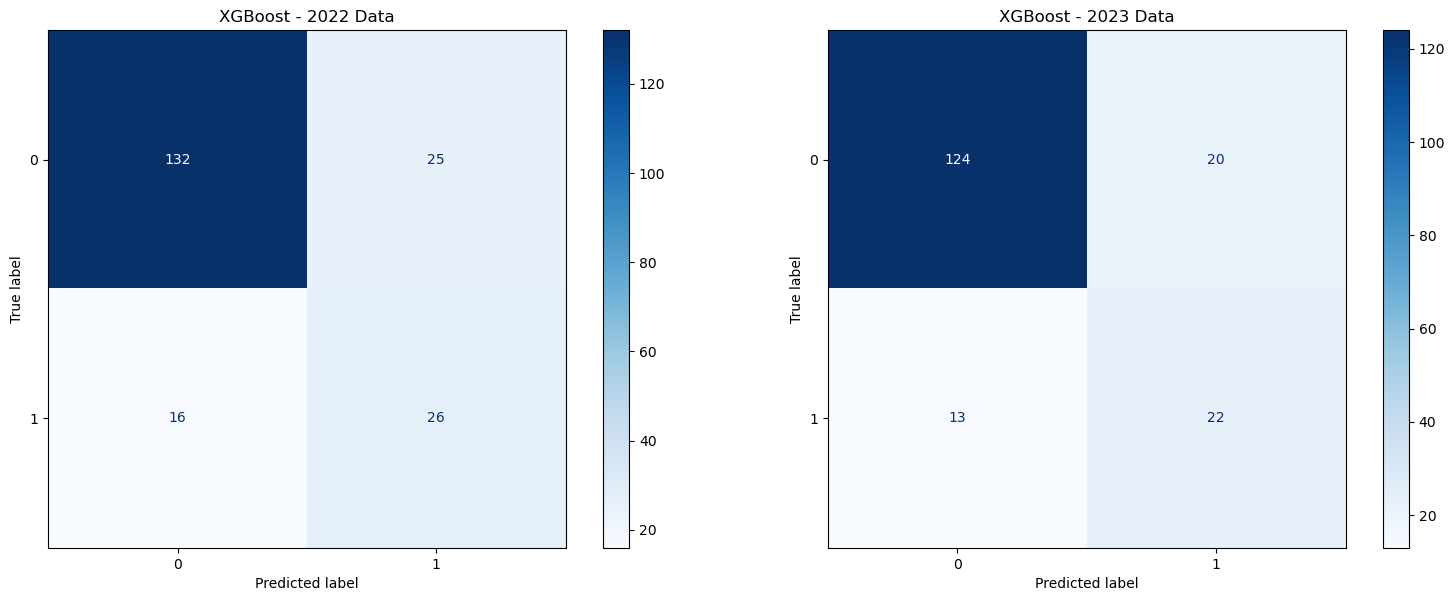


Calculating Permutation Feature Importance for 2023 data...


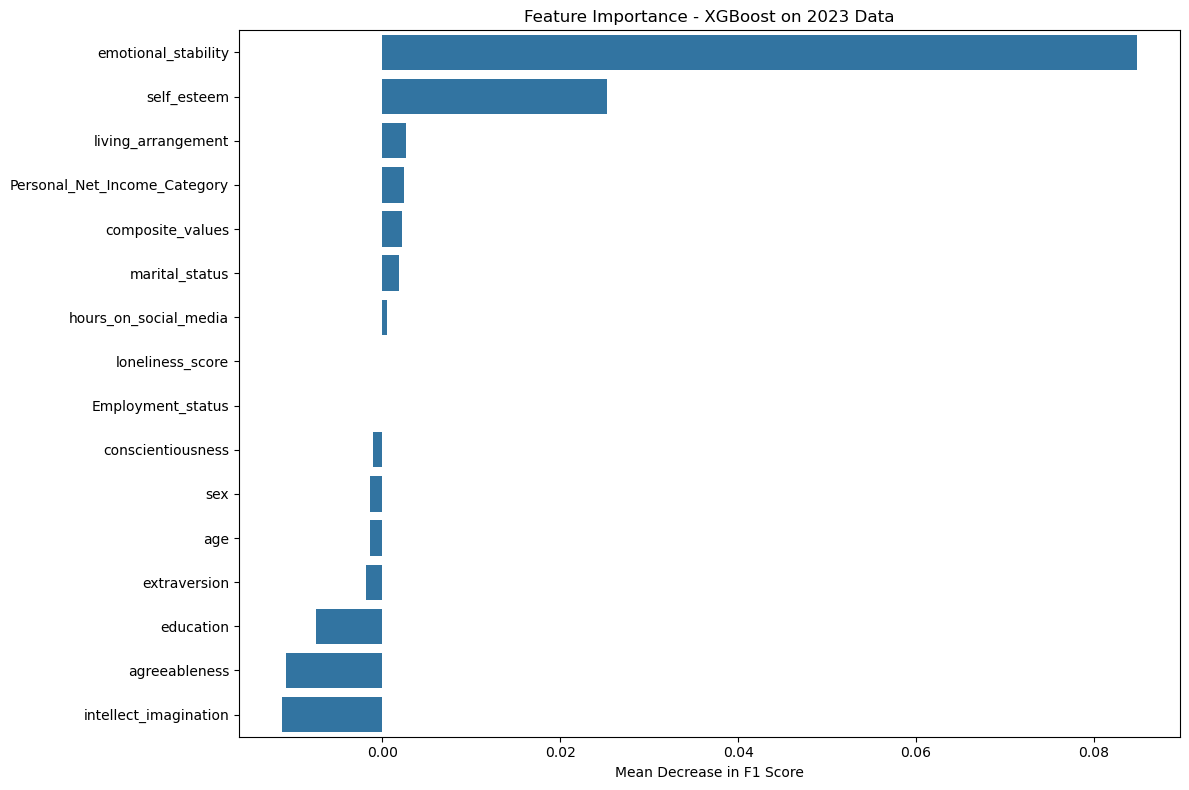


Top 10 Most Important Features (2023):
emotional_stability: 0.0849 ± 0.0231
self_esteem: 0.0253 ± 0.0137
living_arrangement: 0.0027 ± 0.0103
Personal_Net_Income_Category: 0.0024 ± 0.0035
composite_values: 0.0022 ± 0.0030
marital_status: 0.0019 ± 0.0033
hours_on_social_media: 0.0005 ± 0.0046
loneliness_score: 0.0000 ± 0.0000
Employment_status: 0.0000 ± 0.0000
conscientiousness: -0.0011 ± 0.0058


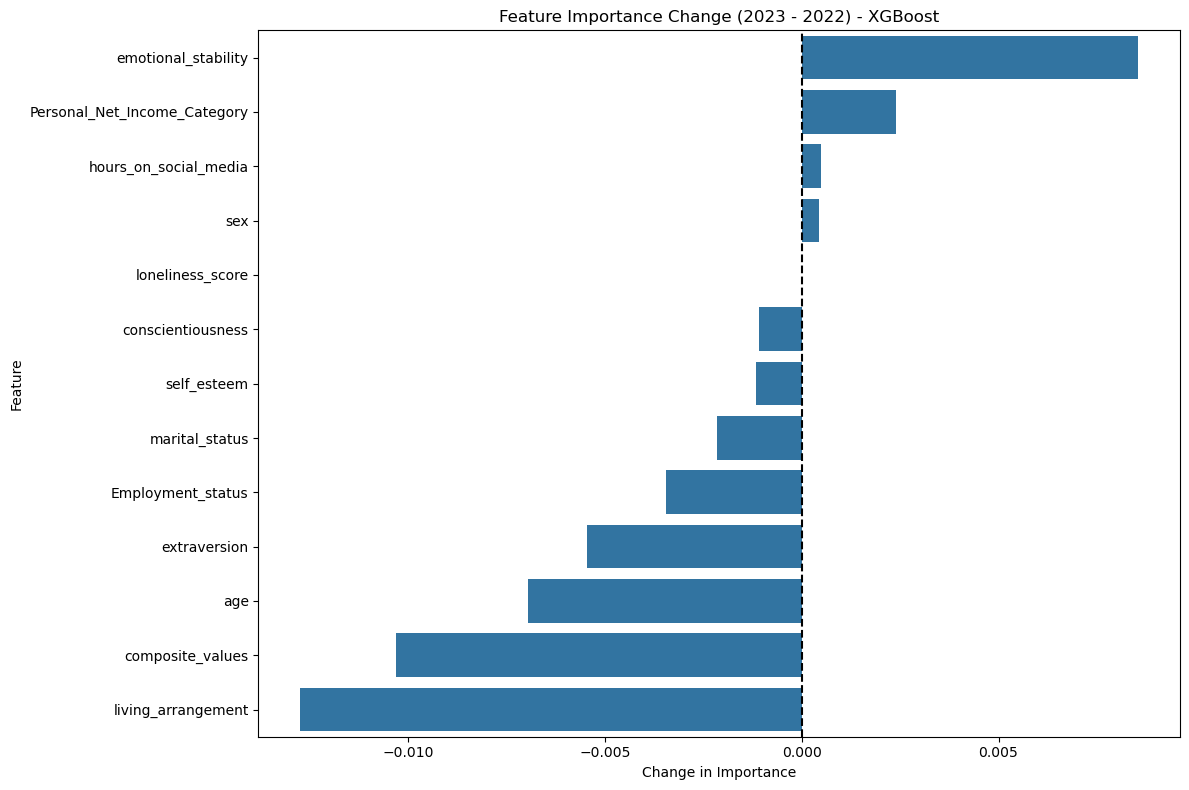


=== Performance Comparison Summary: 2022 vs 2023 ===
Metric            2022      2023    Change
------------------------------------------
Accuracy        0.7940    0.8156    0.0217
F1 Score        0.8009    0.8217    0.0208
Precision       0.8113    0.8306    0.0193
Recall          0.7940    0.8156    0.0217
AUC-ROC         0.8214    0.8508    0.0294
Avg Prec        0.5265    0.5312    0.0047


In [60]:
# Continue from previous code - Add these visualizations for 2023 data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay,
    roc_curve, 
    auc, 
    precision_recall_curve, 
    average_precision_score
)
from sklearn.inspection import permutation_importance

# We already predicted y_pred_2023 using best_estimator
# Get probabilities for 2023 data if the model supports it
if hasattr(best_estimator, "predict_proba"):
    y_proba_2023 = best_estimator.predict_proba(X_test_2023_clean)[:, 1]
    
    # === ROC Curve for 2023 ===
    plt.figure(figsize=(10, 8))
    fpr_2023, tpr_2023, _ = roc_curve(y_test_2023, y_proba_2023)
    roc_auc_2023 = auc(fpr_2023, tpr_2023)
    plt.plot(fpr_2023, tpr_2023, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_2023:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_name} on 2023 Data')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"AUC-ROC (2023): {roc_auc_2023:.4f}")
    
    # === Precision-Recall Curve for 2023 ===
    plt.figure(figsize=(10, 8))
    precision_2023, recall_2023, _ = precision_recall_curve(y_test_2023, y_proba_2023)
    pr_auc_2023 = average_precision_score(y_test_2023, y_proba_2023)
    plt.plot(recall_2023, precision_2023, color='green', lw=2, 
             label=f'Precision-Recall curve (AP = {pr_auc_2023:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {best_model_name} on 2023 Data')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()
    print(f"Average Precision (2023): {pr_auc_2023:.4f}")
    
    # Compare 2022 vs 2023 ROC curves on one plot
    plt.figure(figsize=(10, 8))
    # Get 2022 ROC curve data (assuming you've already calculated this)
    fpr_2022, tpr_2022, _ = roc_curve(y_test, y_proba)
    roc_auc_2022 = auc(fpr_2022, tpr_2022)
    
    plt.plot(fpr_2022, tpr_2022, color='blue', lw=2, label=f'2022 ROC (AUC = {roc_auc_2022:.4f})')
    plt.plot(fpr_2023, tpr_2023, color='red', lw=2, label=f'2023 ROC (AUC = {roc_auc_2023:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve Comparison - {best_model_name} (2022 vs 2023)')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Compare 2022 vs 2023 Precision-Recall curves on one plot
    plt.figure(figsize=(10, 8))
    # Get 2022 PR curve data (assuming you've already calculated this)
    precision_2022, recall_2022, _ = precision_recall_curve(y_test, y_proba)
    pr_auc_2022 = average_precision_score(y_test, y_proba)
    
    plt.plot(recall_2022, precision_2022, color='blue', lw=2, label=f'2022 PR Curve (AP = {pr_auc_2022:.4f})')
    plt.plot(recall_2023, precision_2023, color='red', lw=2, label=f'2023 PR Curve (AP = {pr_auc_2023:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve Comparison - {best_model_name} (2022 vs 2023)')
    plt.legend(loc="upper right")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(f"Note: {best_model_name} does not support probability predictions for ROC and PR curves")

# === Confusion Matrix for 2023 ===
plt.figure(figsize=(8, 6))
cm_2023 = confusion_matrix(y_test_2023, y_pred_2023)
disp_2023 = ConfusionMatrixDisplay(confusion_matrix=cm_2023)
disp_2023.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name} on 2023 Data')
plt.show()

# Print confusion matrix values
print("\nConfusion Matrix (2023):")
print(f"True Negatives: {cm_2023[0,0]}")
print(f"False Positives: {cm_2023[0,1]}")
print(f"False Negatives: {cm_2023[1,0]}")
print(f"True Positives: {cm_2023[1,1]}")

# Display 2022 vs 2023 confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# 2022 CM
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp1.plot(ax=axes[0], cmap='Blues')
axes[0].set_title(f'{best_model_name} - 2022 Data')
# 2023 CM
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_2023, display_labels=[0, 1])
disp2.plot(ax=axes[1], cmap='Blues')
axes[1].set_title(f'{best_model_name} - 2023 Data')
plt.tight_layout()
plt.show()

# === Permutation Feature Importance for 2023 ===
print("\nCalculating Permutation Feature Importance for 2023 data...")
result_2023 = permutation_importance(
    best_estimator, 
    X_test_2023_clean, 
    y_test_2023, 
    scoring='f1_weighted', 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1
)

# Get feature names for 2023 data
feature_names_2023 = X_test_2023.columns if hasattr(X_test_2023, 'columns') else [f"Feature {i}" for i in range(X_test_2023.shape[1])]

# Sort features by importance
sorted_idx_2023 = result_2023.importances_mean.argsort()[::-1]

# Plot feature importance for 2023
plt.figure(figsize=(12, 8))
sns.barplot(
    x=result_2023.importances_mean[sorted_idx_2023], 
    y=[feature_names_2023[i] for i in sorted_idx_2023]
)
plt.title(f"Feature Importance - {best_model_name} on 2023 Data")
plt.xlabel("Mean Decrease in F1 Score")
plt.tight_layout()
plt.show()

# Print top features with importance values for 2023
print("\nTop 10 Most Important Features (2023):")
for i in sorted_idx_2023[:10]:
    feature_name = feature_names_2023[i]
    print(f"{feature_name}: {result_2023.importances_mean[i]:.4f} ± {result_2023.importances_std[i]:.4f}")

# Compare feature importances between 2022 and 2023
# Get top 10 features from both years
top_features_2022 = [feature_names[i] for i in sorted_idx[:10]]
top_importances_2022 = result.importances_mean[sorted_idx[:10]]

top_features_2023 = [feature_names_2023[i] for i in sorted_idx_2023[:10]]
top_importances_2023 = result_2023.importances_mean[sorted_idx_2023[:10]]

# Create a feature comparison dataframe
import pandas as pd
comparison_df = pd.DataFrame({
    'Feature': list(set(top_features_2022 + top_features_2023)),
})

# Add importances for 2022
for feature in comparison_df['Feature']:
    if feature in top_features_2022:
        idx = top_features_2022.index(feature)
        comparison_df.loc[comparison_df['Feature'] == feature, '2022_Importance'] = top_importances_2022[idx]
    else:
        comparison_df.loc[comparison_df['Feature'] == feature, '2022_Importance'] = 0

# Add importances for 2023
for feature in comparison_df['Feature']:
    if feature in top_features_2023:
        idx = top_features_2023.index(feature)
        comparison_df.loc[comparison_df['Feature'] == feature, '2023_Importance'] = top_importances_2023[idx]
    else:
        comparison_df.loc[comparison_df['Feature'] == feature, '2023_Importance'] = 0

# Calculate importance change
comparison_df['Change'] = comparison_df['2023_Importance'] - comparison_df['2022_Importance']
comparison_df = comparison_df.sort_values('Change', ascending=False)

# Plot feature importance change
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Change',
    y='Feature',
    data=comparison_df
)
plt.title(f"Feature Importance Change (2023 - 2022) - {best_model_name}")
plt.xlabel("Change in Importance")
plt.axvline(x=0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Print summary statistics comparing 2022 and 2023 performance
print("\n=== Performance Comparison Summary: 2022 vs 2023 ===")
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate metrics for 2022
accuracy_2022 = accuracy_score(y_test, y_pred)
f1_2022 = f1_score(y_test, y_pred, average='weighted')
precision_2022 = precision_score(y_test, y_pred, average='weighted')
recall_2022 = recall_score(y_test, y_pred, average='weighted')

# Calculate metrics for 2023
accuracy_2023 = accuracy_score(y_test_2023, y_pred_2023)
f1_2023 = f1_score(y_test_2023, y_pred_2023, average='weighted')
precision_2023 = precision_score(y_test_2023, y_pred_2023, average='weighted')
recall_2023 = recall_score(y_test_2023, y_pred_2023, average='weighted')

# Print comparison table
print(f"{'Metric':<12}{'2022':>10}{'2023':>10}{'Change':>10}")
print(f"{'-'*42}")
print(f"{'Accuracy':<12}{accuracy_2022:>10.4f}{accuracy_2023:>10.4f}{accuracy_2023-accuracy_2022:>10.4f}")
print(f"{'F1 Score':<12}{f1_2022:>10.4f}{f1_2023:>10.4f}{f1_2023-f1_2022:>10.4f}")
print(f"{'Precision':<12}{precision_2022:>10.4f}{precision_2023:>10.4f}{precision_2023-precision_2022:>10.4f}")
print(f"{'Recall':<12}{recall_2022:>10.4f}{recall_2023:>10.4f}{recall_2023-recall_2022:>10.4f}")
if 'roc_auc_2022' in locals() and 'roc_auc_2023' in locals():
    print(f"{'AUC-ROC':<12}{roc_auc_2022:>10.4f}{roc_auc_2023:>10.4f}{roc_auc_2023-roc_auc_2022:>10.4f}")
if 'pr_auc_2022' in locals() and 'pr_auc_2023' in locals():
    print(f"{'Avg Prec':<12}{pr_auc_2022:>10.4f}{pr_auc_2023:>10.4f}{pr_auc_2023-pr_auc_2022:>10.4f}")